# Tratamiento del dataframe 
Se ha extraido de a base de datos un daframe en formato pickle

## Imports

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sql_face.tables import *
import os


## Leer dataframe del disco
se especifica directorio y fichero

In [ ]:
home = os.path.expanduser("~")

input_dir = os.path.join(home, 'video_resources', 'sql_database')
df = pd.read_pickle(os.path.join(input_dir,'df.pkl'))


In [131]:
df.columns

Index(['identity', 'pitch', 'angle_pitch', 'yaw', 'angle_yaw', 'roll',
       'angle_roll', 'source', 'gender', 'headgear', 'age', 'age_number',
       'glasses', 'type', 'beard', 'emotion', 'other_occlusions', 'race',
       'image_id', 'Detector', 'E_Model', 'Q_model', 'Q_group'],
      dtype='object')

In [139]:
df2 = df.loc[df['type'] == 'enfsiImage']
df2.drop('E_Model', axis = 1,inplace = True)
df2 = df2.reset_index(drop=True)
len(df2)


16370

In [140]:
df2 = df2.drop_duplicates(subset = ['image_id','Detector','Q_model','Q_group'])

In [ ]:

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

In [ ]:
df2.Q_group


In [141]:

#convertimos a String los Enum
variables = ['Q_group','gender','yaw','pitch','roll','emotion','race']
for var in variables:
    df2[var] = df2[var].apply(lambda x: x.value if x else None)


variables += ['Detector', 'Q_model']
df_plot = df2[variables]


In [ ]:


# Calcular el coeficiente de Cramér V para cada par de variables
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            coef = cramers_v(df2[var1], df2[var2])
            print(f"Coeficiente de Cramér V entre {var1} y {var2}: {coef}")

In [ ]:




# Visualizar la relación entre cada par de variables utilizando gráficos de conteo (countplots) y mapas de calor (heatmaps)
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            # Gráfico de conteo (countplot)
            plt.figure(figsize=(10, 6))
            sns.countplot(x=var1, hue=var2, data=df2)
            plt.title(f'Relación entre {var1} y {var2}')
            plt.show()

            # Mapa de calor (heatmap)
            contingency_table = pd.crosstab(df2[var1], df2[var2])
            normalized_table = contingency_table / contingency_table.sum(axis=1)[:, np.newaxis]
            plt.figure(figsize=(10, 6))
            sns.heatmap(normalized_table, annot=True, fmt=".2f", cmap="YlGnBu")
            plt.title(f'Relación entre {var1} y {var2}')
            plt.show()


In [143]:
# Asumiendo que 'df2' es tu DataFrame
variables = ['Detector', 'Q_model', 'gender']

# Transformar el DataFrame en formato "long"
df_long = df2.melt(
    id_vars="Q_group",
    value_vars=variables,
    var_name="variable",
    value_name="value",
)


In [144]:
df_long

,Q_group,variable,value
0,High,Detector,mtcnn
1,Very high,Detector,mtcnn
2,Medium,Detector,mtcnn
3,High,Detector,mtcnn
4,Low,Detector,mtcnn
...,...,...,...
9817,Low,gender,Woman
9818,Low,gender,Man
9819,Medium,gender,Woman
9820,Low,gender,Woman


In [ ]:


# Crear una gráfica facetada de conteo (countplot)
g = sns.catplot(
    data=df2,
    x="Q_group",
    kind="count",
    col_order=sorted(df2["Q_group"].unique()),
    row="variable",
    hue="value",
    col_wrap=1,
    sharey=False,
    col="Q_group",
    height=4,
    aspect=2,
    margin_titles=True,
)

# Ajustar los títulos de las gráficas
g.set_titles(row_template="{row_name}", col_template="{col_name}")

# Mostrar la gráfica
plt.show()

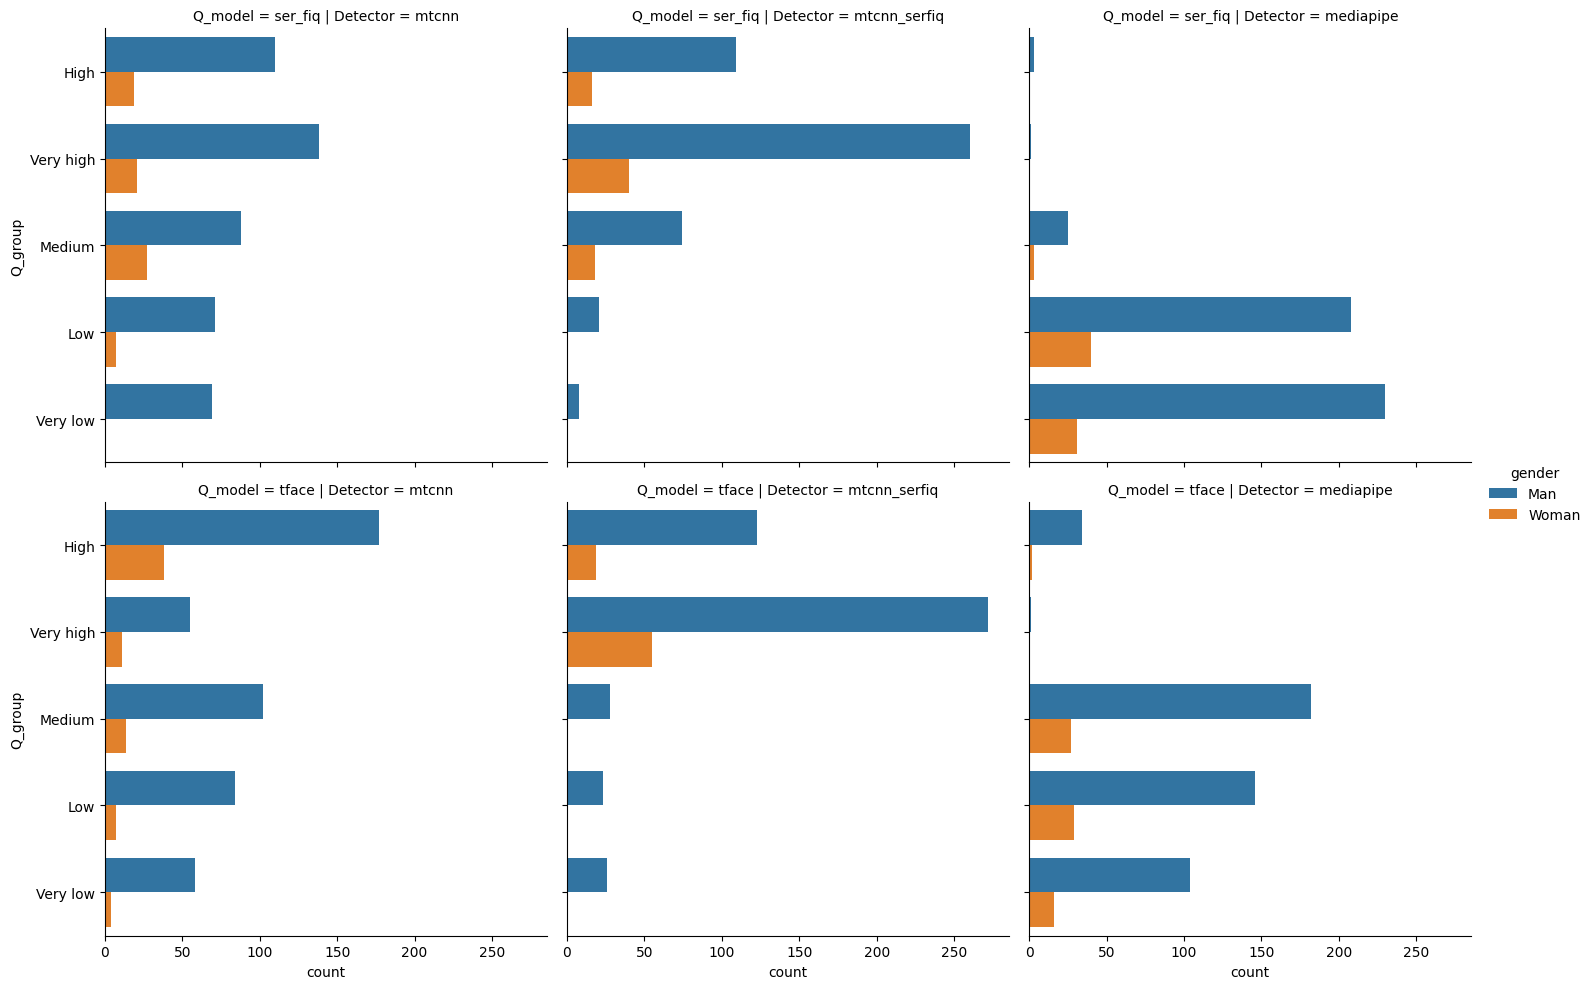

In [145]:
g = sns.catplot(y='Q_group',row= "Q_model",col='Detector',hue='gender',kind = 'count', data= df_plot)
plt.show()

In [ ]:
import plotly.express as px

fig = px.treemap(df_plot, path=['Q_group', 'Q_model', 'Detector', 'gender'], title="Mosaic Plot")
fig.show()

In [150]:


# Tabla de contingencia para Quality_group y Detector
contingency_table_detector = pd.crosstab(df2['Q_group'], df2['Detector'])

# Tabla de contingencia para Quality_group y Quality_model
contingency_table_quality_model = pd.crosstab(df2['Q_group'], df2['Q_model'])

# Tabla de contingencia para Quality_group y yaw
contingency_table_yaw = pd.crosstab(df2['Q_group'], df2['yaw'])

# Tabla de contingencia para Quality_group y gender
contingency_table_gender = pd.crosstab(df2['Q_group'], df2['gender'])


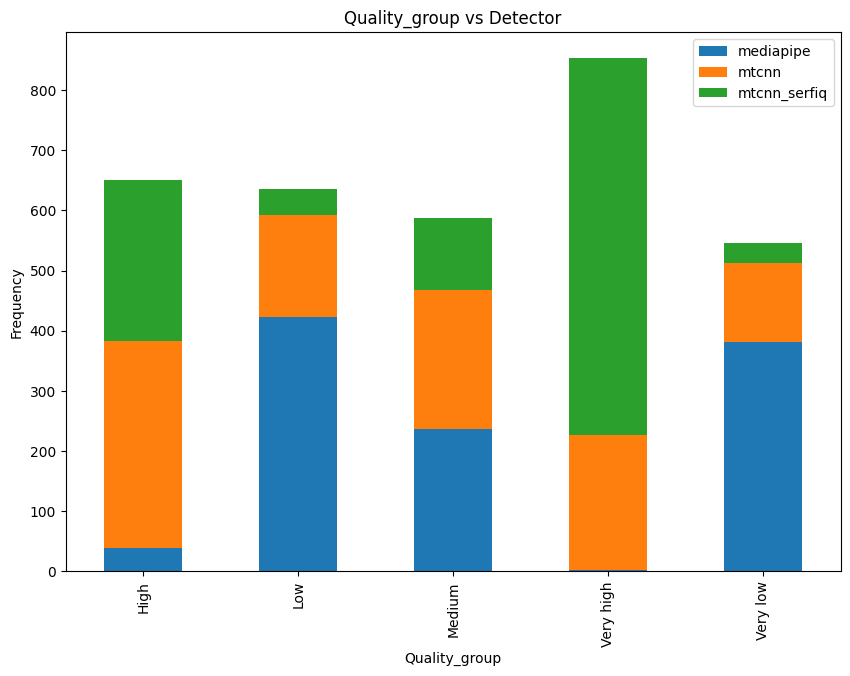

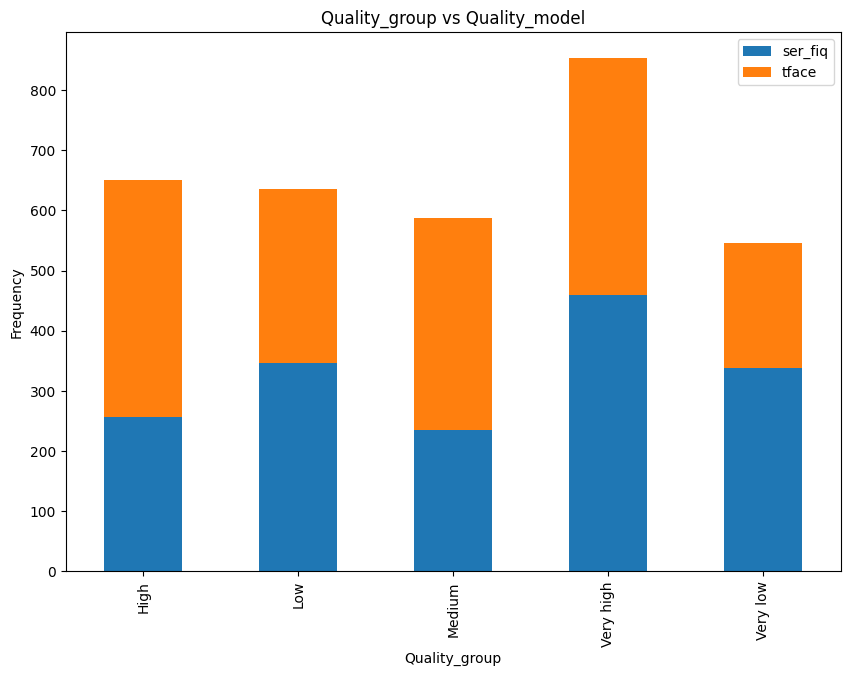

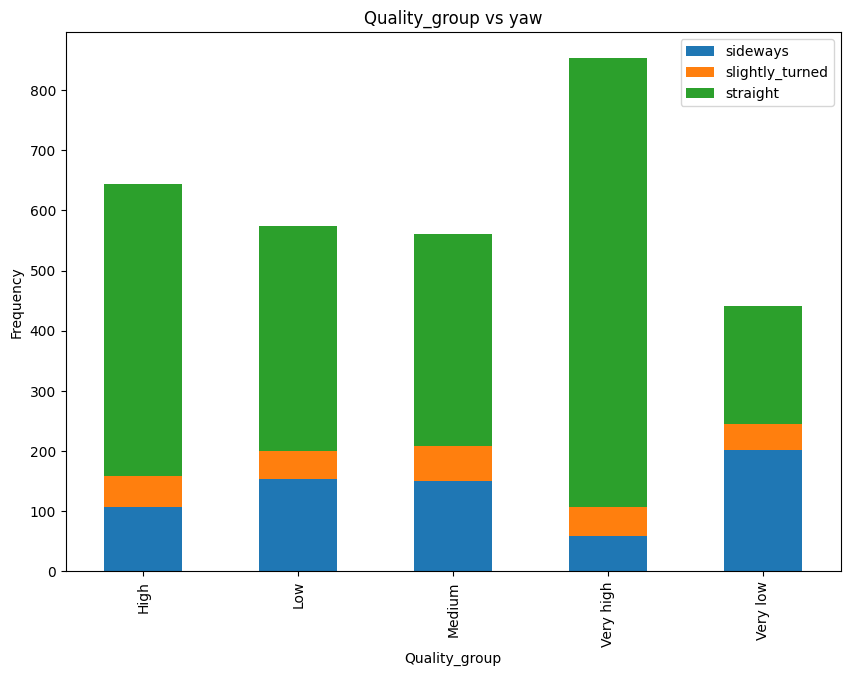

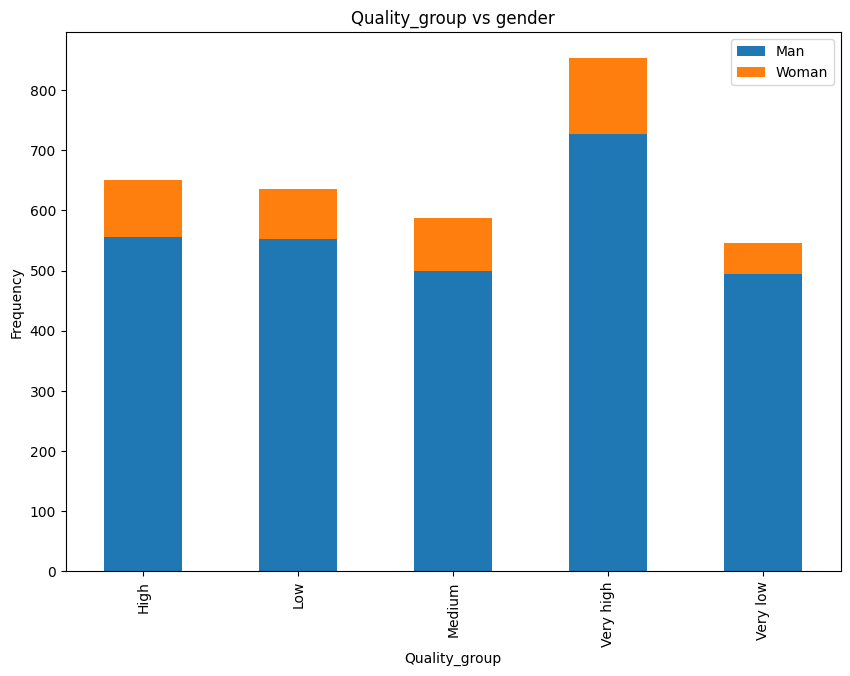

In [154]:
import matplotlib.pyplot as plt

def plot_stacked_bar(contingency_table, title, xlabel, ylabel):
    ax = contingency_table.plot(kind='bar', stacked=True, figsize=(10, 7))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

plot_stacked_bar(contingency_table_detector, 'Quality_group vs Detector', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_quality_model, 'Quality_group vs Quality_model', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_yaw, 'Quality_group vs yaw', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_gender, 'Quality_group vs gender', 'Quality_group', 'Frequency')


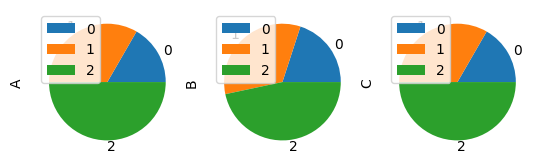

In [152]:
df = pd.DataFrame({"A": [10, 20, 30], "B": [15, 25, 35], "C": [5, 10, 15]})
df.plot(kind="pie", subplots=True)
plt.show()